In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import noisereduce as nr
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

c:\Users\gabry\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preparation

## Loading Data

In [2]:
# Konfigurasi
DATASET_PATH = "dataset"
COMMANDS = ["baca", "berhenti", "foto", "halo", "info", "kembali", "ulang"]

In [3]:
# Load data
X = []
y = []

for label in COMMANDS:
    folder_path = os.path.join(DATASET_PATH, label)
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder_path, filename)
            X.append(file_path)
            y.append(label)

X = np.array(X)  
y = np.array(y)

In [4]:
len(X)

2541

In [5]:
# Buat dataframe
df = pd.DataFrame()
df['speech'] = X 
df['label'] = y

df.head()

,speech,label
0,dataset\baca\baca1.wav,baca
1,dataset\baca\baca10.wav,baca
2,dataset\baca\baca100.wav,baca
3,dataset\baca\baca101.wav,baca
4,dataset\baca\baca102.wav,baca


In [6]:

df['label'].value_counts()

label
kembali     368
foto        364
baca        363
berhenti    363
ulang       363
info        361
halo        359
Name: count, dtype: int64

In [7]:
# Tahapan Preprocessing
def load_audio(file_path, sr=16000):
    audio, sample_rate = librosa.load(file_path, sr=sr)
    return audio, sample_rate

def standardize_audio(audio, sample_rate, duration=1.0):
    target_length = int(sample_rate * duration)
    if len(audio) > target_length:
        audio = audio[:target_length]
    else:
        audio = np.pad(audio, (0, target_length - len(audio)))
    return audio

def reduce_noise(audio, sample_rate):
    return nr.reduce_noise(y=audio, sr=sample_rate)

def normalize_audio(audio):
    return audio / np.max(np.abs(audio))

def decompose_audio(audio, sample_rate):
    stft = np.abs(librosa.stft(audio, n_fft=512, hop_length=256))
    return stft.flatten()

In [8]:
def full_preprocessing_pipeline(file_path):
    """Process a single audio file through the full pipeline"""
    audio, sr = load_audio(file_path)
    audio = standardize_audio(audio, sr)
    audio = reduce_noise(audio, sr)
    audio = normalize_audio(audio)
    features = decompose_audio(audio, sr)
    return features

# Get the number of available CPU cores
num_cores = multiprocessing.cpu_count()

# Use parallel processing to apply the function to all rows
dfn = df.copy()
dfn['decomposed'] = Parallel(n_jobs=num_cores)(
    delayed(full_preprocessing_pipeline)(file_path) 
    for file_path in dfn['speech']
)

dfn.head()

,speech,label,decomposed
0,dataset\baca\baca1.wav,baca,"[1.2507292e-05, 5.309764e-05, 0.030100526, 0.0..."
1,dataset\baca\baca10.wav,baca,"[0.006619213, 0.014825445, 0.009506131, 0.0029..."
2,dataset\baca\baca100.wav,baca,"[4.494204e-05, 9.340041e-09, 5.3256088e-08, 2...."
3,dataset\baca\baca101.wav,baca,"[1.41630735e-05, 5.604483e-07, 8.554762e-06, 8..."
4,dataset\baca\baca102.wav,baca,"[8.6215756e-08, 3.3914738e-09, 1.3588887e-09, ..."


In [9]:
# def full_preprocessing_pipeline(file_path):
#     audio, sr = load_audio(file_path)
#     audio = standardize_audio(audio, sr)
#     audio = reduce_noise(audio, sr)
#     audio = normalize_audio(audio)
#     features = decompose_audio(audio, sr)
#     return features

# dfn = df.copy()
# dfn['decomposed'] = dfn['speech'].apply(full_preprocessing_pipeline)
# dfn.head()

## Exploratory Data Analysis

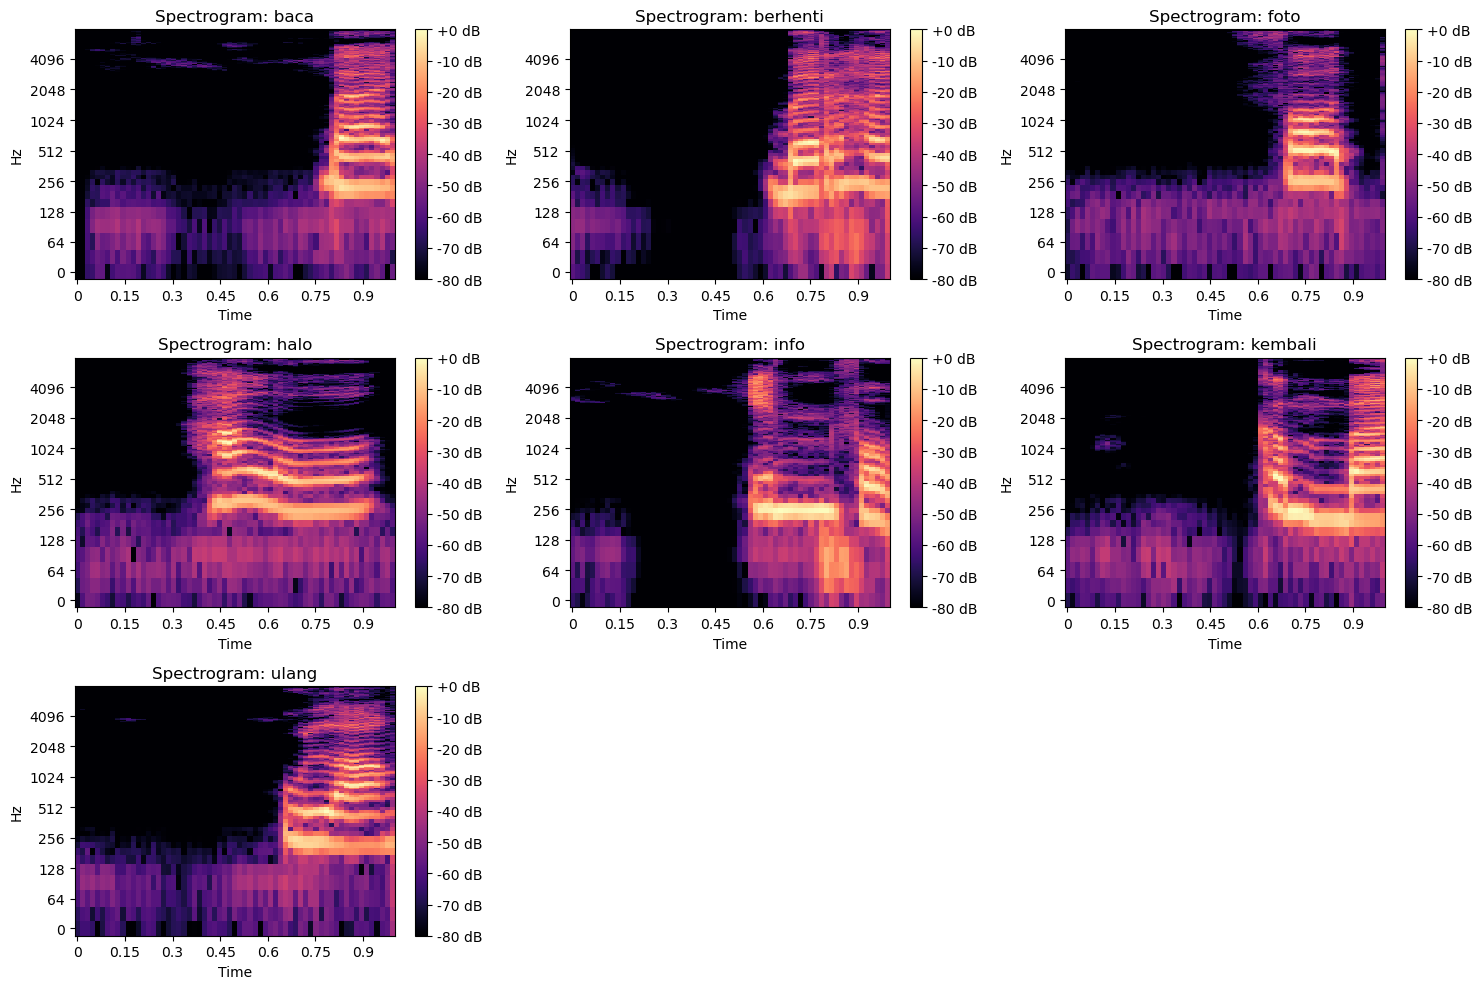

In [10]:
def visualize_stft_per_label(dfn):
    labels = dfn['label'].unique()
    
    plt.figure(figsize=(15, 10))

    for i, label in enumerate(labels):
        example_path = dfn[dfn['label'] == label]['speech'].values[0]
        
        # Preprocessing
        audio, sr = load_audio(example_path)
        audio = standardize_audio(audio, sr)
        audio = reduce_noise(audio, sr)
        audio = normalize_audio(audio)

        # Dekomposisi: STFT
        stft = np.abs(librosa.stft(audio, n_fft=512, hop_length=256))

        # Plot
        plt.subplot(3, 3, i + 1)
        librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max),
                                 sr=sr, hop_length=256, x_axis='time', y_axis='log')
        plt.title(f'Spectrogram: {label}')
        plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

# Panggil fungsi
visualize_stft_per_label(dfn)


## MFCC

In [11]:
def extract_mfcc(audio, sample_rate, n_mfcc=13):
    """Extract MFCC features from audio"""
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return mfcc.T  # shape: (time_steps, n_mfcc)

def full_mfcc_pipeline(file_path):
    """Full processing pipeline for a single audio file"""
    audio, sr = load_audio(file_path)
    audio = standardize_audio(audio, sr)
    audio = reduce_noise(audio, sr)
    audio = normalize_audio(audio)
    return extract_mfcc(audio, sr)

def parallel_mfcc_extraction(file_paths, n_jobs=-1):
    """
    Process multiple audio files in parallel to extract MFCC features
    Args:
        file_paths: List of audio file paths
        n_jobs: Number of parallel jobs (-1 for all available cores)
    Returns:
        List of MFCC features for each file
    """
    return Parallel(n_jobs=n_jobs)(
        delayed(full_mfcc_pipeline)(file_path)
        for file_path in tqdm(file_paths, desc="Extracting MFCC features")
    )

# Usage
dfn = df.copy()
dfn['mfcc'] = parallel_mfcc_extraction(dfn['speech'].values)
dfn.head()

Extracting MFCC features: 100%|██████████| 2541/2541 [00:26<00:00, 96.46it/s] 


,speech,label,mfcc
0,dataset\baca\baca1.wav,baca,"[[-560.0277, 7.0940065, 7.0144014, 6.882761, 6..."
1,dataset\baca\baca10.wav,baca,"[[-542.4045, 9.172295, 10.295028, 14.567551, 7..."
2,dataset\baca\baca100.wav,baca,"[[-617.2266, -3.732782, 3.5783176, -3.325787, ..."
3,dataset\baca\baca101.wav,baca,"[[-636.81616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
4,dataset\baca\baca102.wav,baca,"[[-499.904, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [12]:
dfn.head(20)

,speech,label,mfcc
0,dataset\baca\baca1.wav,baca,"[[-560.0277, 7.0940065, 7.0144014, 6.882761, 6..."
1,dataset\baca\baca10.wav,baca,"[[-542.4045, 9.172295, 10.295028, 14.567551, 7..."
2,dataset\baca\baca100.wav,baca,"[[-617.2266, -3.732782, 3.5783176, -3.325787, ..."
3,dataset\baca\baca101.wav,baca,"[[-636.81616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
4,dataset\baca\baca102.wav,baca,"[[-499.904, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,dataset\baca\baca103.wav,baca,"[[-519.58954, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
6,dataset\baca\baca104.wav,baca,"[[-517.4239, 27.727215, 26.183313, 23.711905, ..."
7,dataset\baca\baca105.wav,baca,"[[-505.73132, 19.461132, 18.835035, 17.81731, ..."
8,dataset\baca\baca106.wav,baca,"[[-534.5835, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
9,dataset\baca\baca107.wav,baca,"[[-517.19257, 3.9717064, 3.951087, 3.9168963, ..."


In [13]:
# # Ekstraksi MFCC
# def extract_mfcc(audio, sample_rate, n_mfcc=13):
#     mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
#     return mfcc.T  # shape: (time_steps, n_mfcc)

# def full_mfcc_pipeline(file_path):
#     audio, sr = load_audio(file_path)
#     audio = standardize_audio(audio, sr)
#     audio = reduce_noise(audio, sr)
#     audio = normalize_audio(audio)
#     mfcc = extract_mfcc(audio, sr)
#     return mfcc

# dfn['mfcc'] = dfn['speech'].apply(full_mfcc_pipeline)

In [14]:
# Konversi MFCC menjadi array 3D: (samples, timesteps, n_mfcc)
X_mfcc = pad_sequences(dfn['mfcc'], padding='post', dtype='float32')  


le = LabelEncoder()
y_encoded = le.fit_transform(dfn['label'])

# Print the encoding assignment
for label, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"'{label}' -> {encoded}")


'baca' -> 0
'berhenti' -> 1
'foto' -> 2
'halo' -> 3
'info' -> 4
'kembali' -> 5
'ulang' -> 6


# Modeling

In [15]:
# Split Data
X_train, X_val, y_train, y_val = train_test_split(
    X_mfcc, y_encoded, test_size=0.1, stratify=y_encoded, random_state=42
    )

In [16]:
# One-hot encoding 
num_classes = len(np.unique(y_encoded))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

In [17]:
# Modeling

model = Sequential([
    # LSTM 
    LSTM(1024, return_sequences=True, input_shape=X_train.shape[1:]),
    LSTM(192, return_sequences=True),
    LSTM(640, return_sequences=True),
    LSTM(192),
    
    # Dense 
    Dense(16, activation='relu'),
    Dense(80, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(112, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [18]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [19]:
# Training
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop]
)

# val_accuracy terbaik
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1  
print(f"Val accuracy terbaik: {best_val_acc:.4f} pada epoch ke-{best_epoch}")

Epoch 1/100
36/36 [==============================] - 12s 90ms/step - loss: 1.5850 - accuracy: 0.3325 - val_loss: 1.2078 - val_accuracy: 0.5373
Epoch 2/100
36/36 [==============================] - 2s 54ms/step - loss: 0.8497 - accuracy: 0.6444 - val_loss: 0.5162 - val_accuracy: 0.7804
Epoch 3/100
36/36 [==============================] - 2s 54ms/step - loss: 0.3900 - accuracy: 0.8600 - val_loss: 0.2553 - val_accuracy: 0.9255
Epoch 4/100
36/36 [==============================] - 2s 54ms/step - loss: 0.2642 - accuracy: 0.9226 - val_loss: 0.1967 - val_accuracy: 0.9373
Epoch 5/100
36/36 [==============================] - 2s 54ms/step - loss: 0.1871 - accuracy: 0.9453 - val_loss: 0.3550 - val_accuracy: 0.8941
Epoch 6/100
36/36 [==============================] - 2s 54ms/step - loss: 0.2850 - accuracy: 0.9164 - val_loss: 0.2202 - val_accuracy: 0.9294
Epoch 7/100
36/36 [==============================] - 2s 54ms/step - loss: 0.1551 - accuracy: 0.9584 - val_loss: 0.1519 - val_accuracy: 0.9412
Epoch

In [20]:
# === EVALUASI ===
loss, accuracy = model.evaluate(X_val, y_val_cat)
print(f"Akurasi Validasi: {accuracy * 100:.2f}%")

8/8 [==============================] - 0s 18ms/step - loss: 0.1355 - accuracy: 0.9725
Akurasi Validasi: 97.25%


In [ ]:
# model.save('mymodel.h5')

: 